# Tea Model Comparisons

### Import Dependencies

In [20]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

In [21]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/Tea.zip", 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

### Reload Data

In [24]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 64
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [25]:
# Set up the base directory
base_dir = "/content/data/"

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 28824 files belonging to 6 classes.


In [27]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [28]:
classes = dataset.class_names
classes

['tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented']

In [12]:
len(dataset)

451

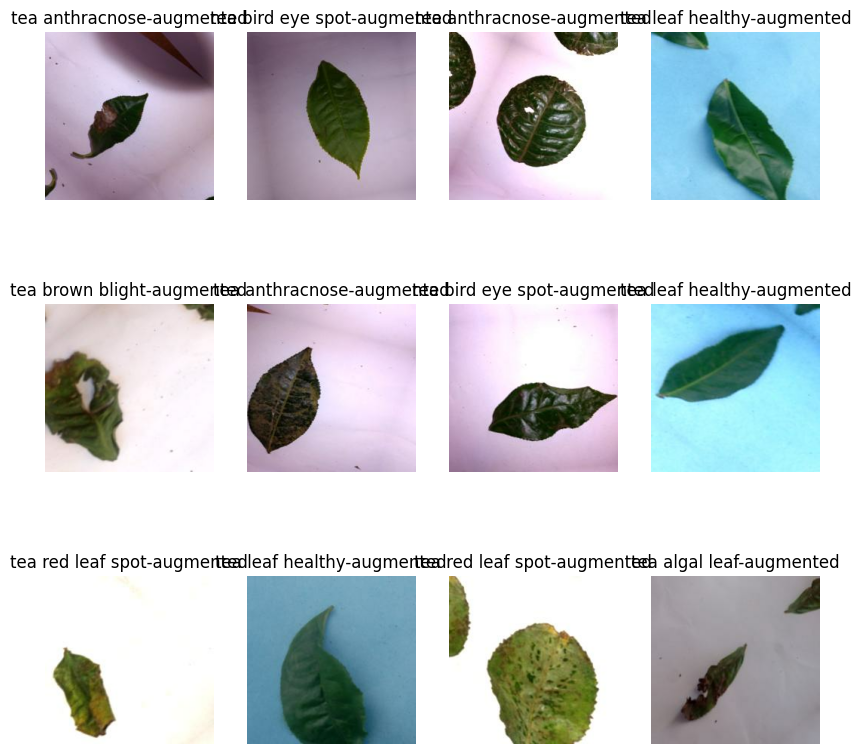

In [13]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [14]:
len(dataset) * 64

28864

### Data Splitting

In [15]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = data_split(dataset)
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 360

Length of Validation Dataset is 67

Length of Testing Dataset is 24


### Model 1: DenseNet121





In [ ]:
model_path = '/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/DenseNet121Model_tea.h5'
Model1_DenseNet = tf.keras.models.load_model(model_path)
Model1_DenseNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
score_train = Model1_DenseNet.evaluate(train_ds)
score_valid = Model1_DenseNet.evaluate(val_ds)
score_test = Model1_DenseNet.evaluate(test_ds)

24/24 [==============================] - 136s 5s/step - loss: 0.0291 - accuracy: 0.9913


first image to predict
actual label: tea leaf healthy-augmented
2/2 [==============================] - 10s 3s/step
predicted label: tea leaf healthy-augmented


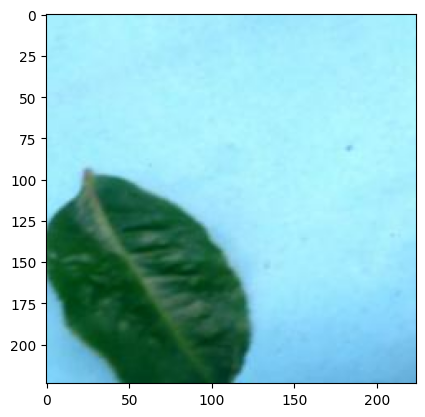

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = Model1_DenseNet.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 130ms/step


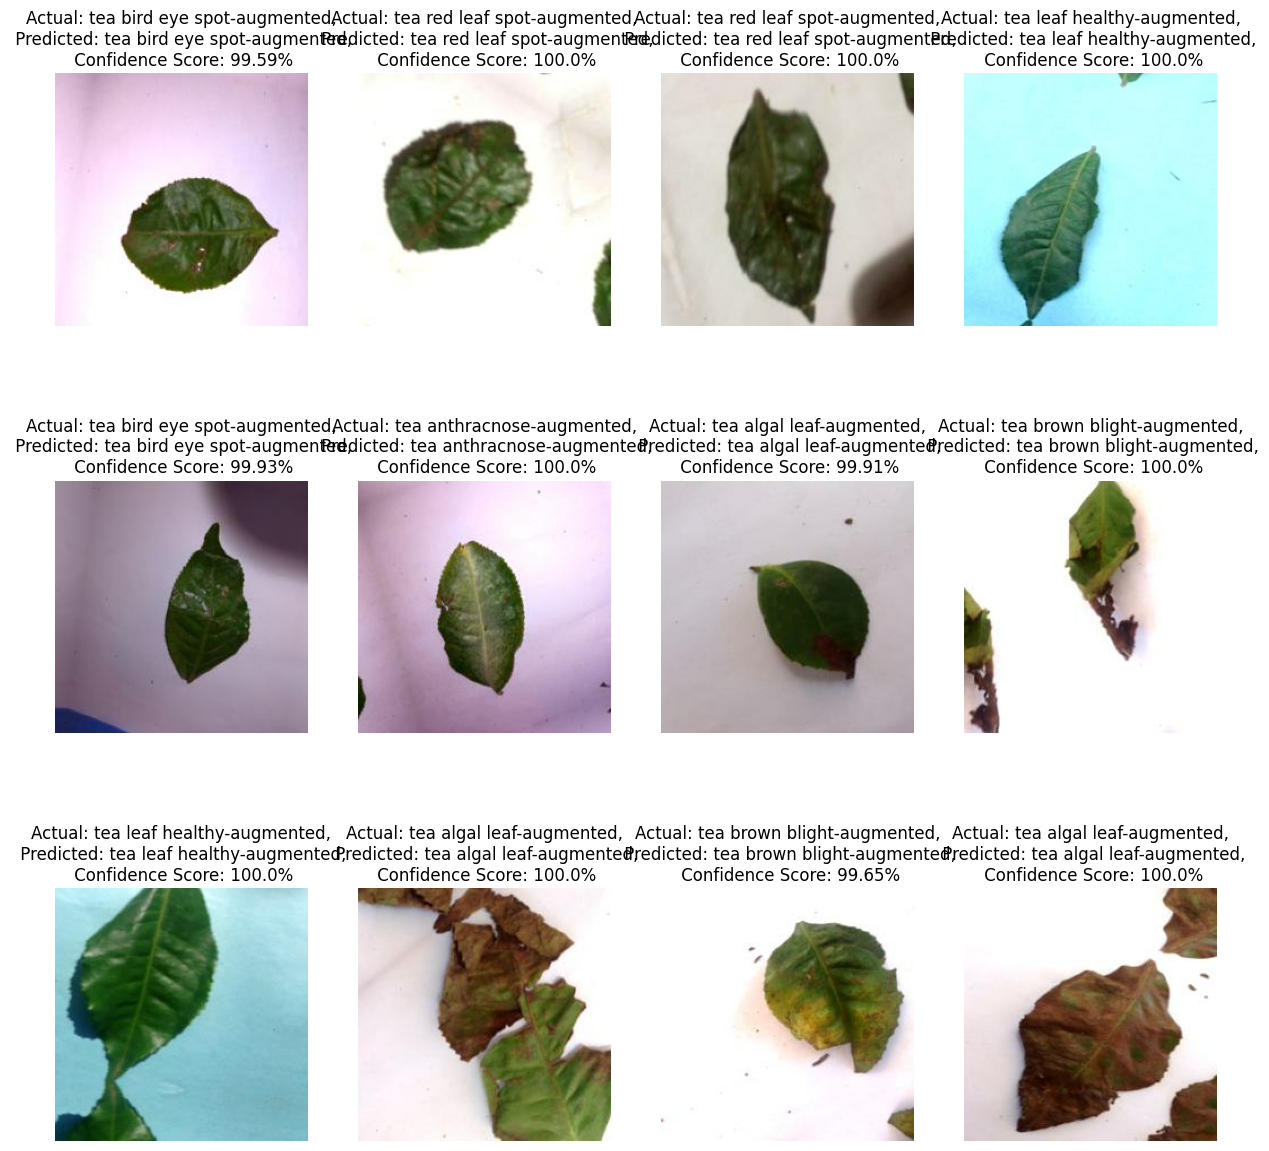

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(Model1_DenseNet,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(Model1_DenseNet,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 107ms/step


In [ ]:
act_class

['tea brown blight-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented',
 'tea bird eye spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea brown blight-augmented',
 'tea red leaf spot-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea algal leaf-augmented',
 'tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea red leaf spot-augmented',
 'tea red leaf spot-augmented',
 'tea brown blight-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea algal leaf-augmented',
 'tea brown blight-augmented',
 'tea anthracnose-augmented',
 'tea algal leaf-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea anthracnose-augmented',
 'tea bird eye s

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

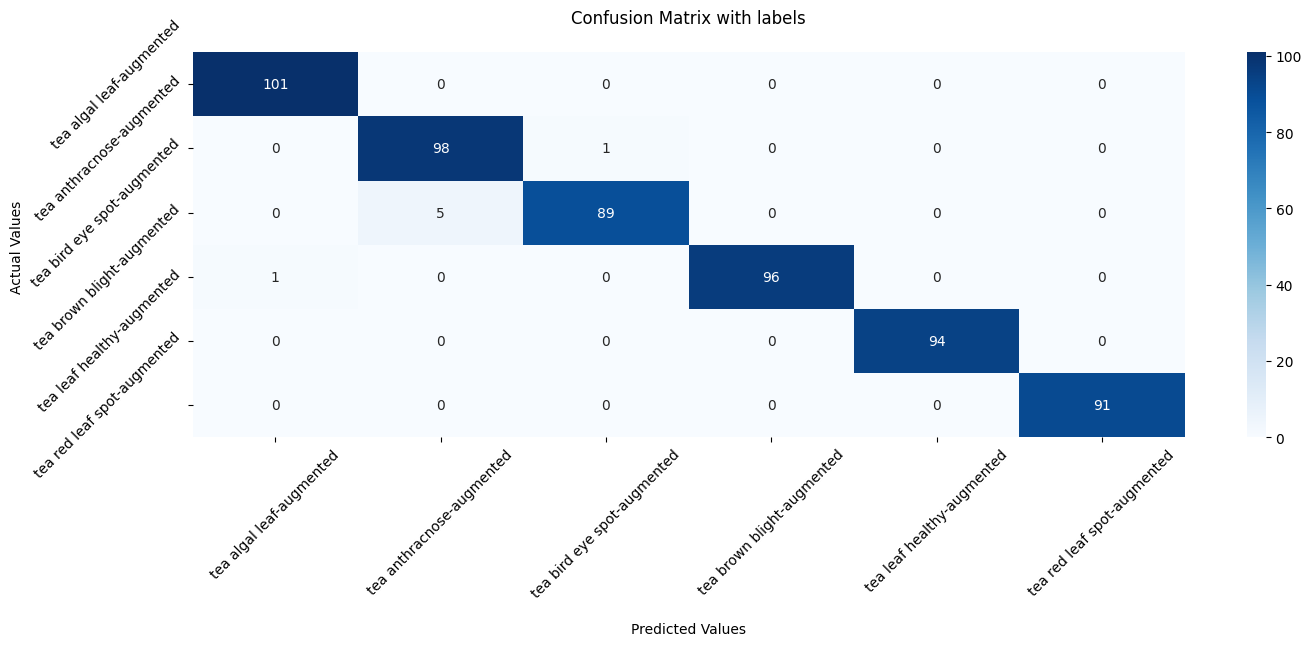

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

### Model 2: Inception121

In [ ]:
model_path = '/content/drive/MyDrive/FINAL_PROJECT/TEA/Inception_Versi2/Inceptionv3_Model_Tea_VERSI2.h5'
Model2_Inception = tf.keras.models.load_model(model_path)
Model2_Inception.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               2621

In [ ]:
score_train = Model2_Inception.evaluate(train_ds)
score_valid = Model2_Inception.evaluate(val_ds)
score_test = Model2_Inception.evaluate(test_ds)

24/24 [==============================] - 97s 3s/step - loss: 0.0325 - accuracy: 0.9915


first image to predict
actual label: tea red leaf spot-augmented
2/2 [==============================] - 5s 2s/step
predicted label: tea red leaf spot-augmented


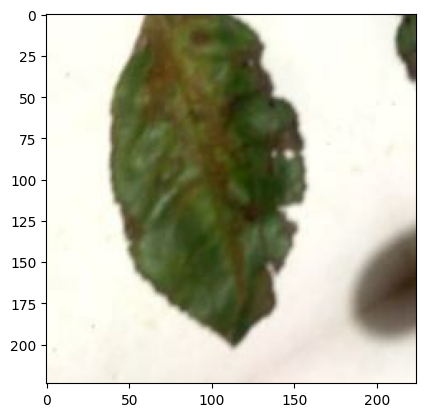

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = Model2_Inception.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 112ms/step


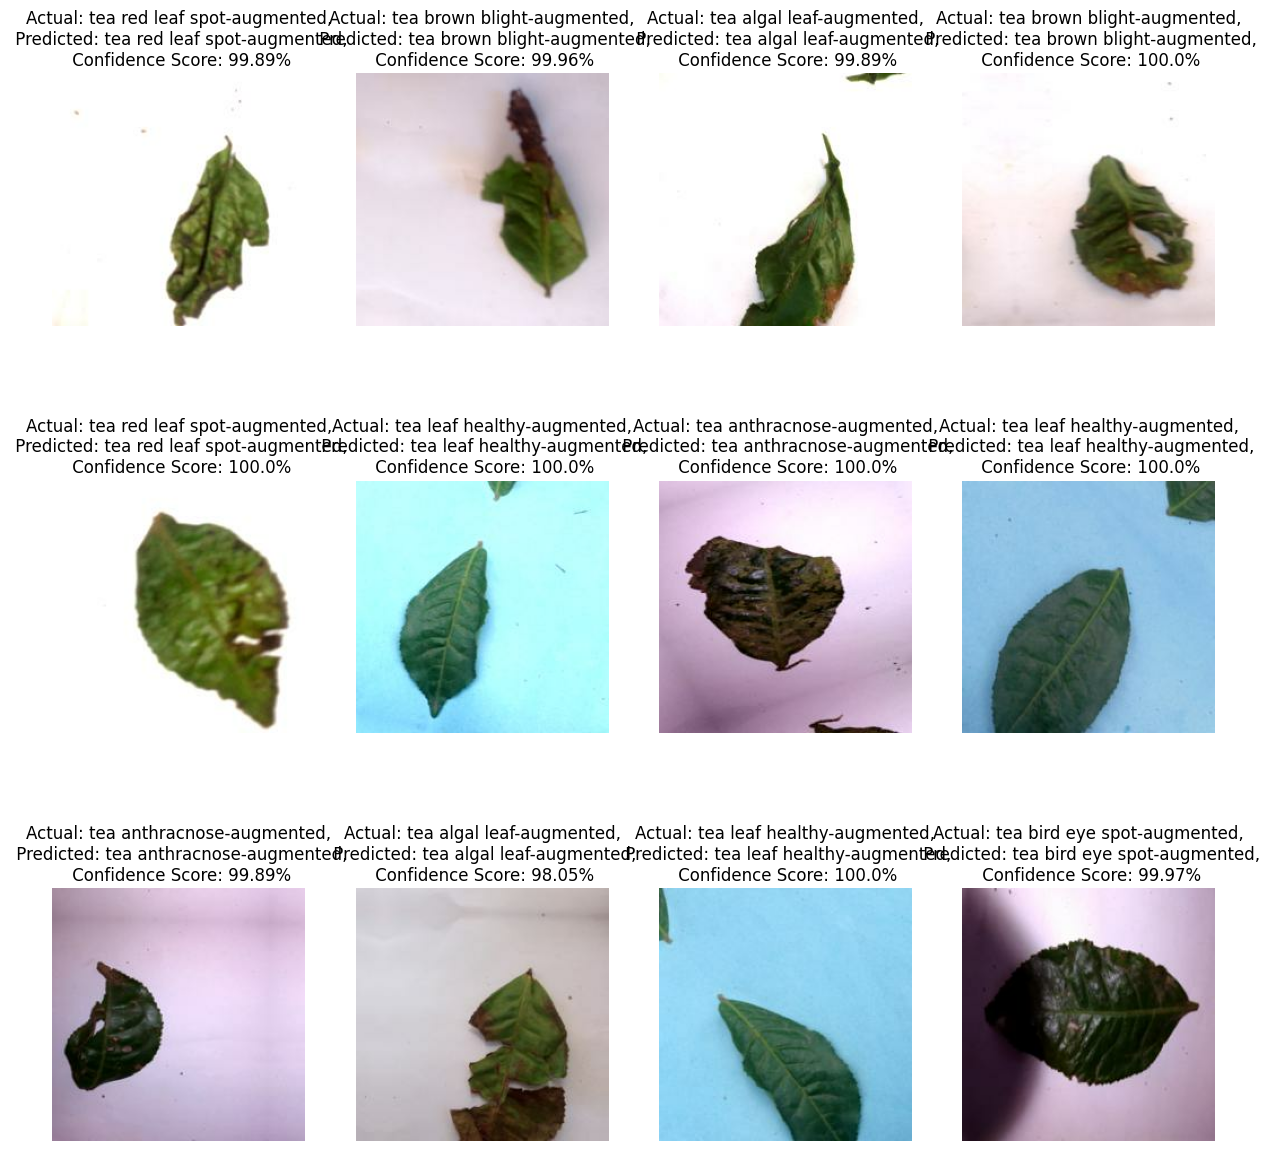

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(Model2_Inception,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(Model2_Inception,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 102ms/step


In [ ]:
act_class

['tea red leaf spot-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented',
 'tea red leaf spot-augmented',
 'tea algal leaf-augmented',
 'tea leaf healthy-augmented',
 'tea anthracnose-augmented',
 'tea brown blight-augmented',
 'tea red leaf spot-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea bird eye spot-augmented',
 'tea anthracnose-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea brown blight-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea red leaf spot-augmented',
 't

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

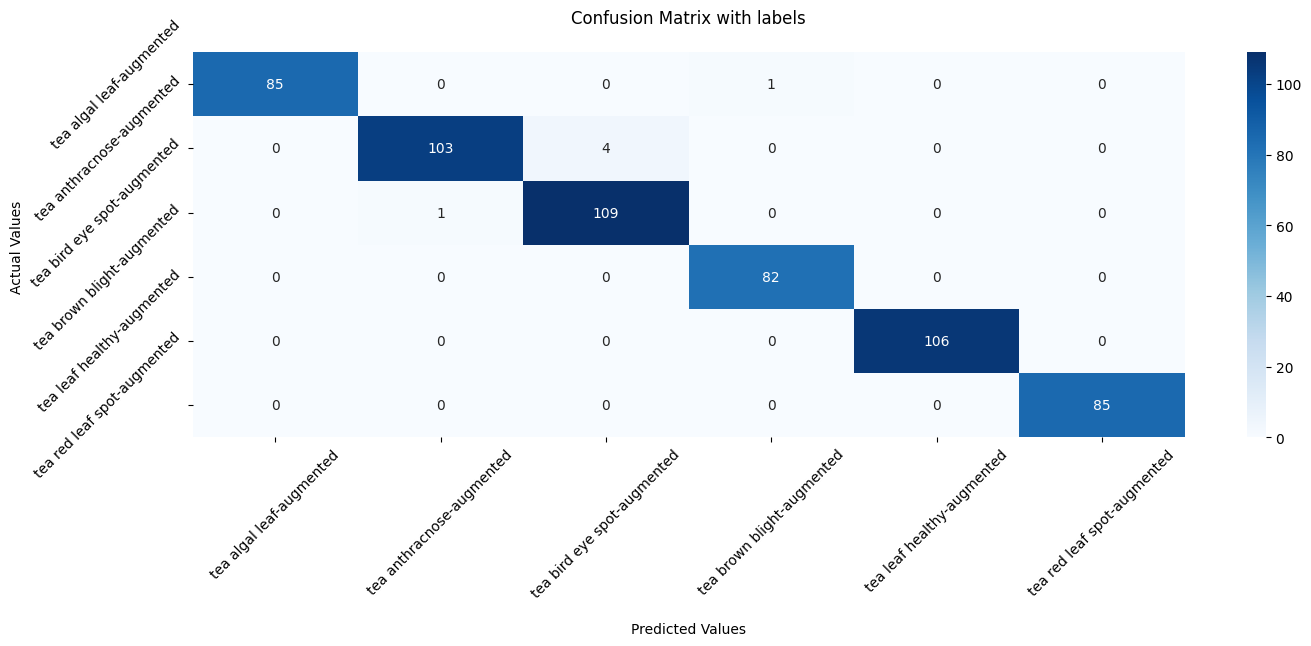

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

### Model 3: resnet50

In [37]:
model_path = '/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/Resnet50Model_tea.h5'
model3_resnet = tf.keras.models.load_model(model_path)
model3_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [ ]:
score_train = model3_resnet.evaluate(train_ds)
score_valid = model3_resnet.evaluate(val_ds)
score_test = model3_resnet.evaluate(test_ds)

24/24 [==============================] - 150s 6s/step - loss: 0.0168 - accuracy: 0.9980


first image to predict
actual label: tea anthracnose-augmented
2/2 [==============================] - 7s 3s/step
predicted label: tea anthracnose-augmented


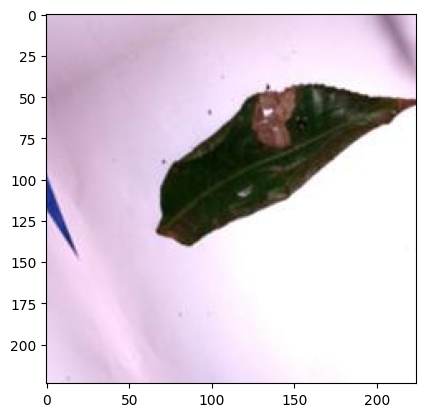

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model3_resnet.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 114ms/step


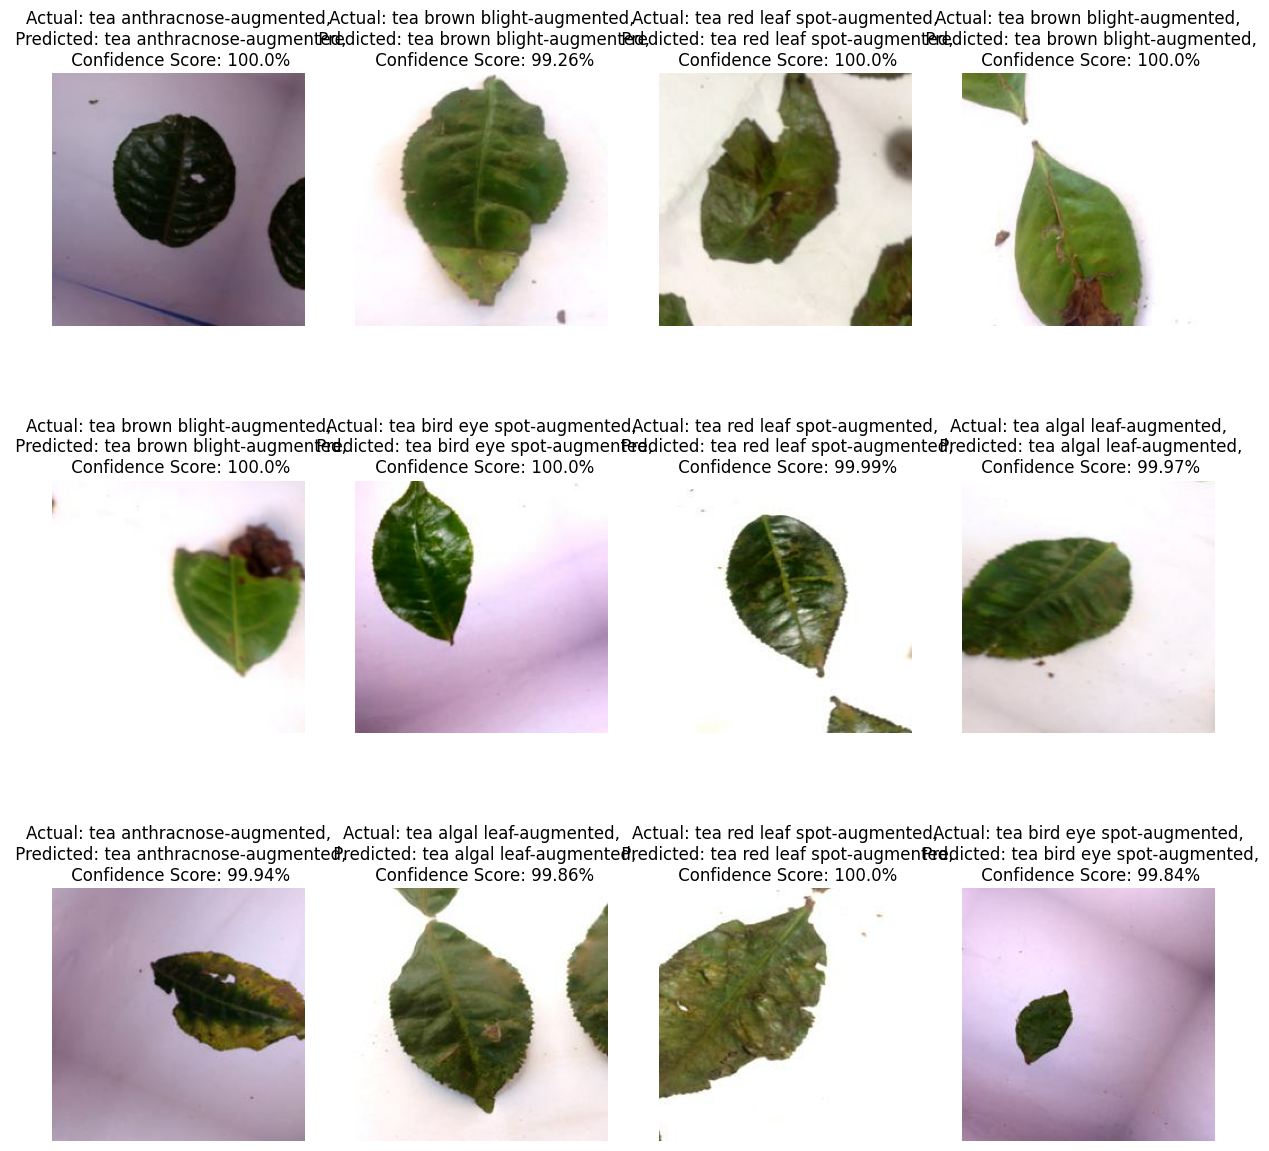

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model3_resnet,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model3_resnet,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 112ms/step


In [ ]:
act_class

['tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea algal leaf-augmented',
 'tea anthracnose-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea anthracnose-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea red leaf spot-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea bird eye spot-augmented',
 'tea red lea

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

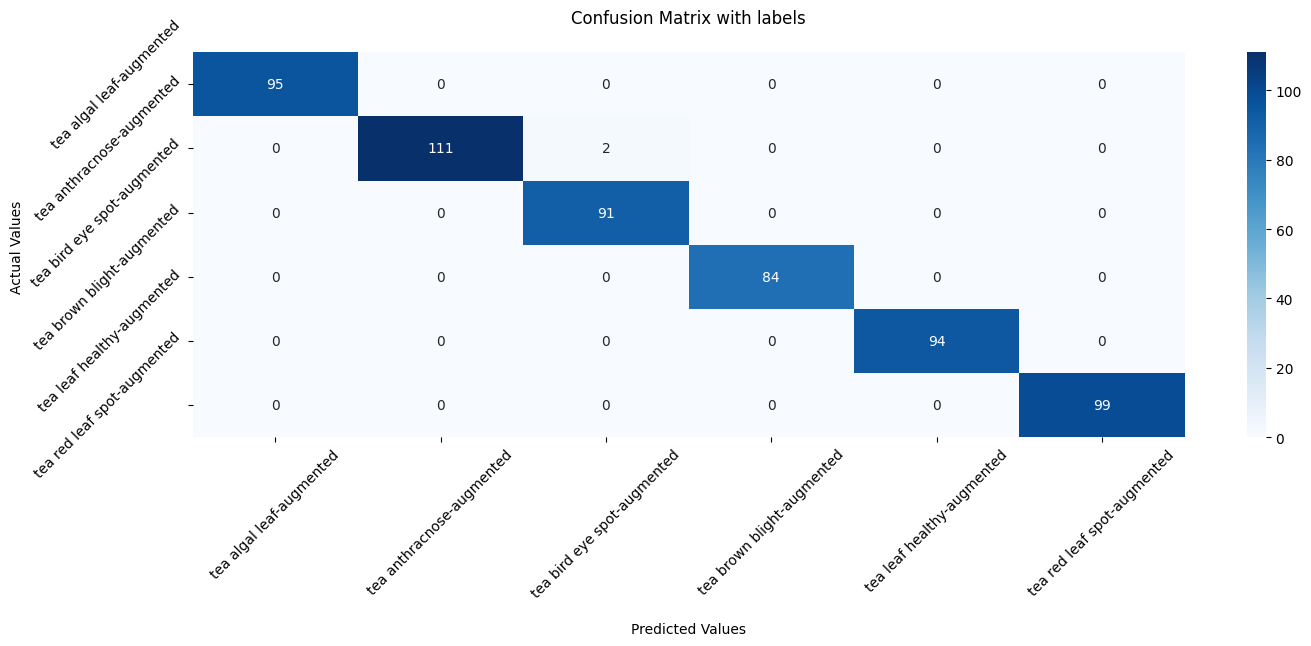

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

### Model 4: MobileNET

In [ ]:
model_path = '/content/drive/MyDrive/FINAL_PROJECT/TEA/MobileNet/MBNetv2Model_Tea.h5'
model4_mobilenet = tf.keras.models.load_model(model_path)
model4_mobilenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
score_train = model4_mobilenet.evaluate(train_ds)
score_valid = model4_mobilenet.evaluate(val_ds)
score_test = model4_mobilenet.evaluate(test_ds)

24/24 [==============================] - 43s 1s/step - loss: 0.0068 - accuracy: 0.9980


first image to predict
actual label: tea brown blight-augmented
2/2 [==============================] - 2s 562ms/step
predicted label: tea brown blight-augmented


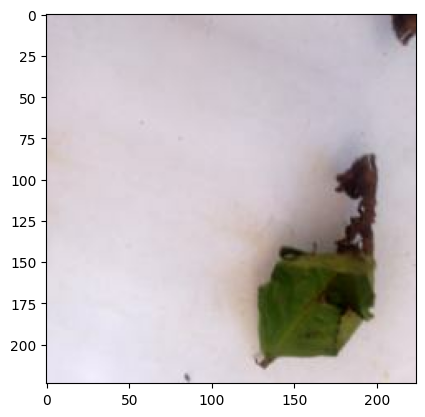

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model4_mobilenet.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


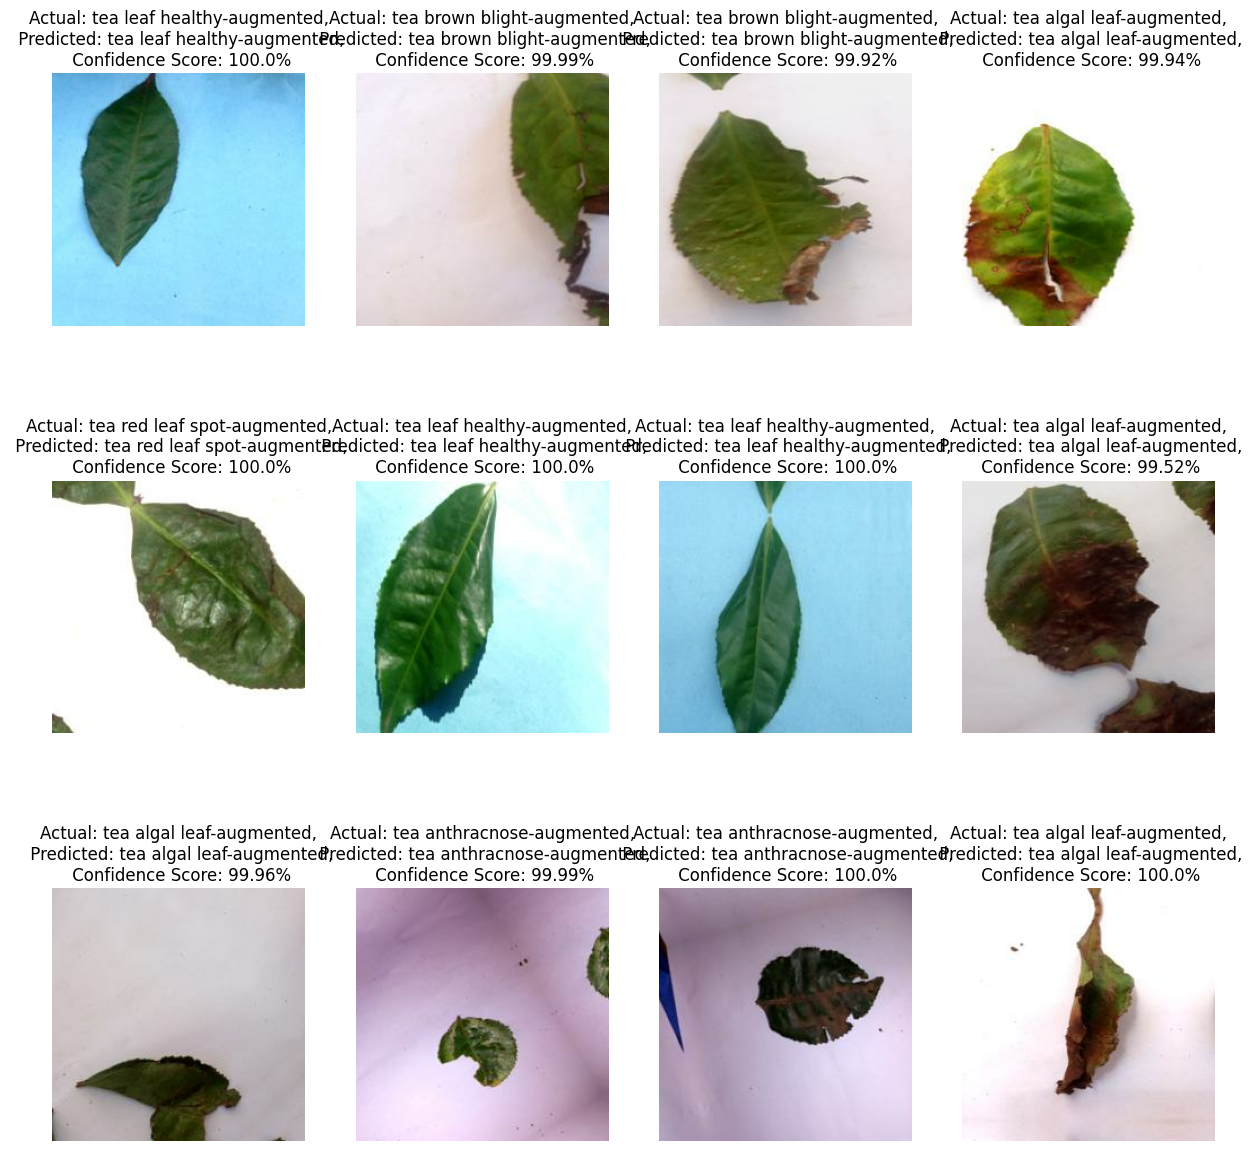

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4_mobilenet,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4_mobilenet,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 54ms/step


In [ ]:
act_class

['tea red leaf spot-augmented',
 'tea algal leaf-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea red leaf spot-augmented',
 'tea bird eye spot-augmented',
 'tea red leaf spot-augmented',
 'tea anthracnose-augmented',
 'tea red leaf spot-augmented',
 'tea leaf healthy-augmented',
 'tea anthracnose-augmented',
 'tea anthracnose-augmented',
 'tea leaf healthy-augmented',
 'tea leaf healthy-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea algal leaf-augmented',
 'tea bird eye spot-augmented',
 'tea algal leaf-augmented',
 'tea algal leaf-augmented',
 'tea brown blight-augmented',
 'tea red leaf spot-augmented',
 'tea red leaf spot-augmented',
 'tea brown blight-augmented',
 'tea leaf healthy-augmented',
 'tea red leaf spot-augmented',
 'tea brown blight-augmented',
 'tea brown blight-augmented',
 'tea anthracnose-augmented',
 'tea bird eye spot-augmented',
 'tea algal l

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

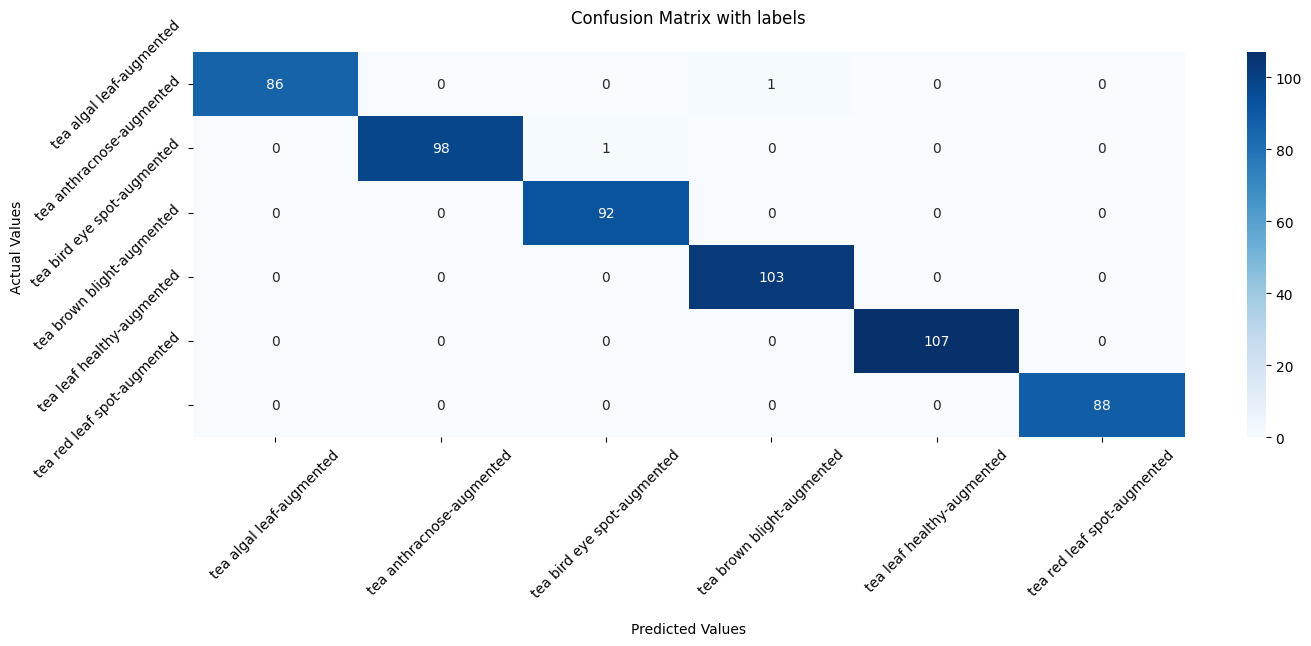

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

### Compiled Comparison

In [29]:
list_modelnames = ["DenseNet_Tea", "Inception_tea", "ResNet50_tea", "mobilenet_TEA"]
dict_histories = {}
saved_model_his = "/content/drive/MyDrive/FINAL_PROJECT/TEA/save_model_history/"

# load model into new variable
for modelname in list_modelnames:
  with open(os.path.join(saved_model_his, modelname), 'rb') as file_pi:
    dict_histories[modelname] = pickle.load(file_pi)

dict_histories.keys()

dict_keys(['DenseNet_Tea', 'Inception_tea', 'ResNet50_tea', 'mobilenet_TEA'])

In [30]:
dict_acc = {}
dict_val_acc = {}
dict_loss = {}
dict_val_loss = {}

for modelname in list_modelnames:
  dict_acc[modelname] = dict_histories[modelname]['accuracy']
  dict_val_acc[modelname] = dict_histories[modelname]['val_accuracy']
  dict_loss[modelname] = dict_histories[modelname]['loss']
  dict_val_loss[modelname] = dict_histories[modelname]['val_loss']

label_plot = ['DenseNet_Tea', 'Inception_Tea','ResNet50_Tea', 'mobilenet_Tea']
marker_plot = ['o','x','v','^']

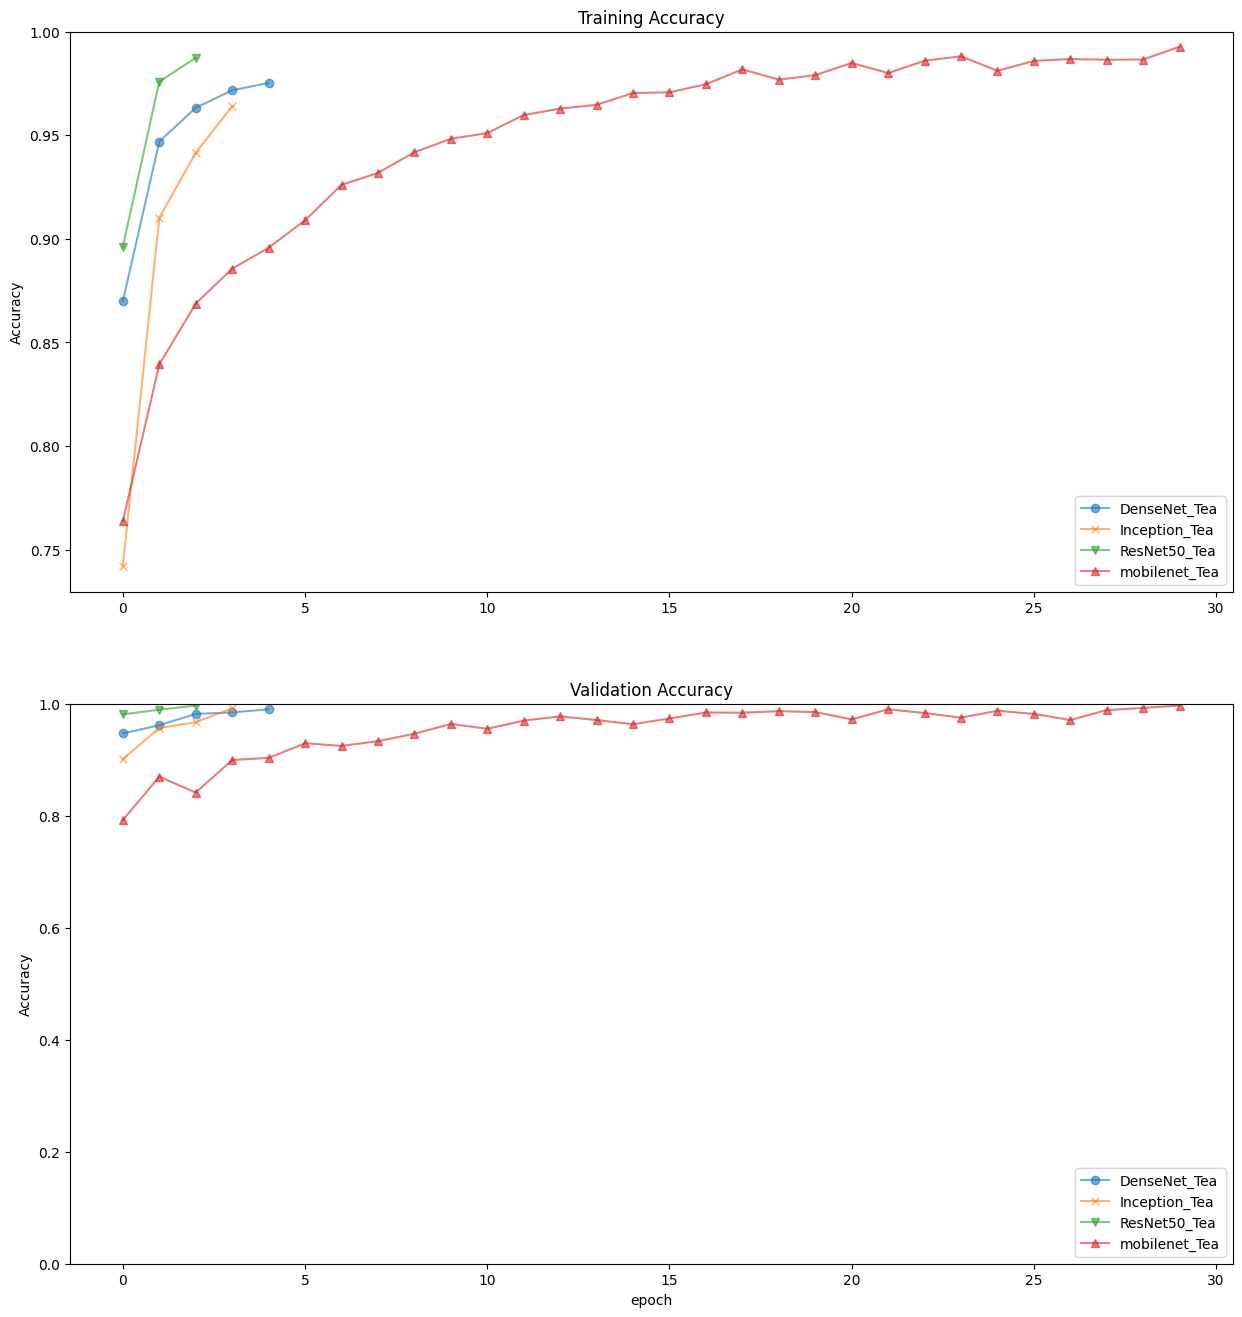

In [31]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)
for i in range(len(list_modelnames)):
  plt.plot(dict_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
for i in range(len(list_modelnames)):
  plt.plot(dict_val_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('acc_all_model.png')

plt.show()

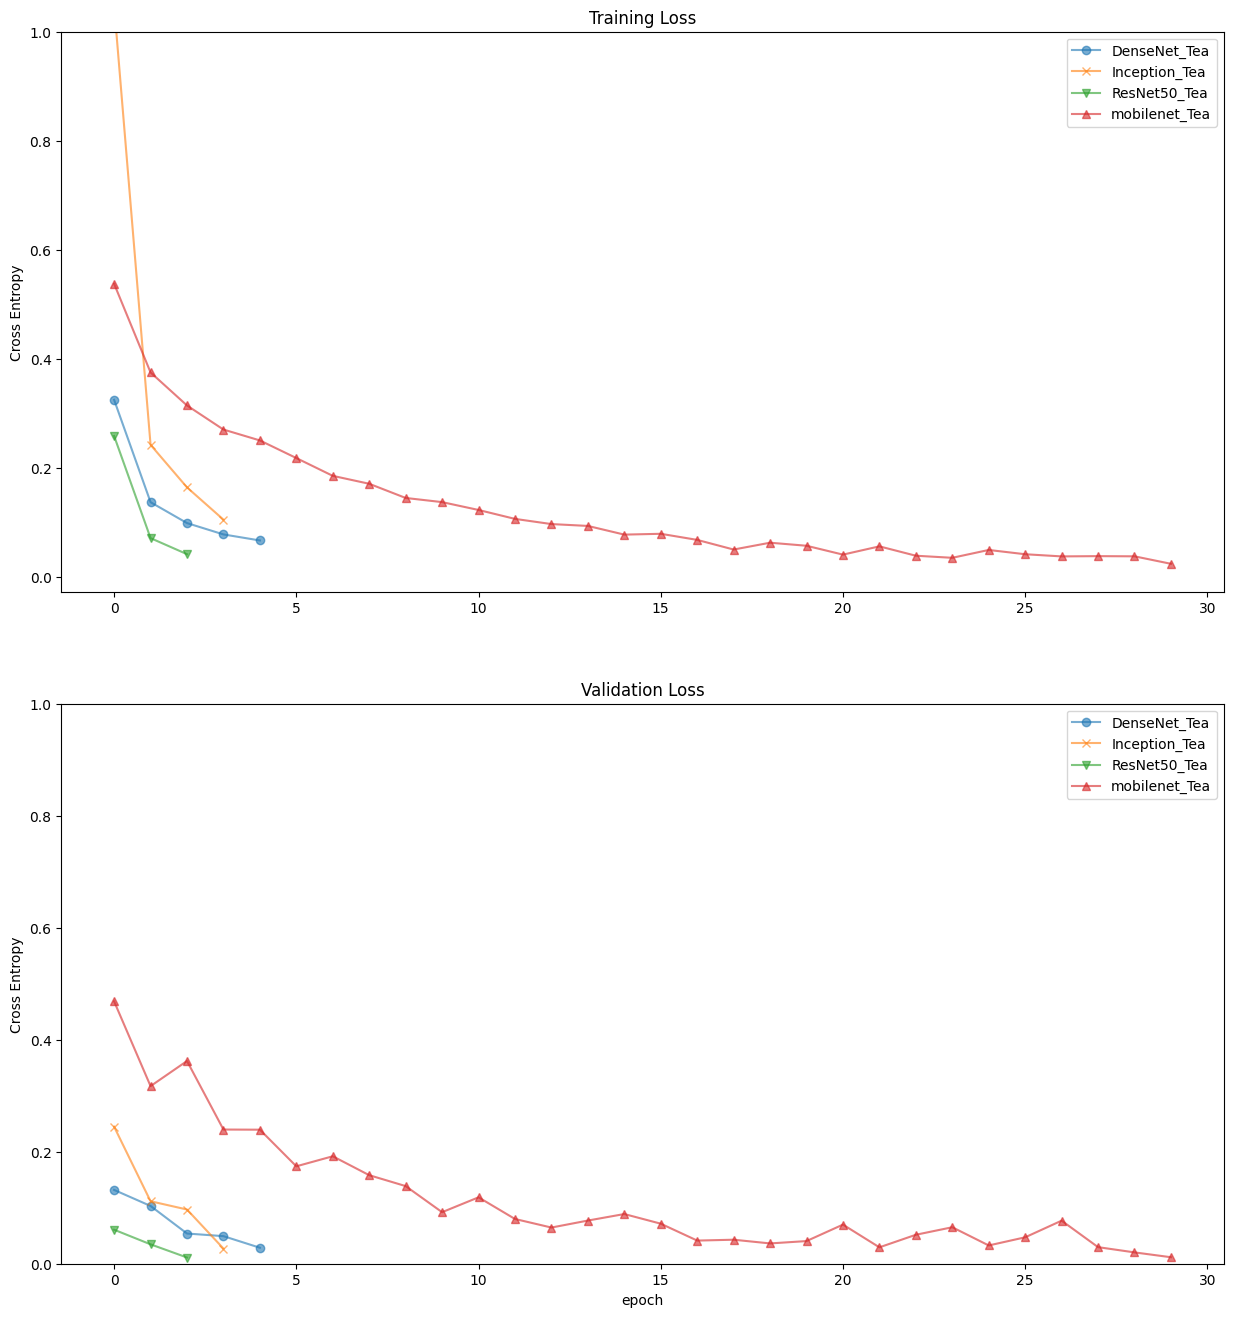

In [32]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)

for i in range(len(list_modelnames)):
  plt.plot(dict_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss')

plt.subplot(2, 1, 2)

for i in range(len(list_modelnames)):
  plt.plot(dict_val_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)
  
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Validation Loss')
plt.xlabel('epoch')

plt.savefig('loss_all_model.png')

plt.show()

In [33]:
model_h5_names = ['/content/drive/MyDrive/FINAL_PROJECT/TEA/DenseNet/DenseNet121Model_tea.h5', '/content/drive/MyDrive/FINAL_PROJECT/TEA/Inception_Versi2/Inceptionv3_Model_Tea_VERSI2.h5', 
                  '/content/drive/MyDrive/FINAL_PROJECT/TEA/RESNET/Resnet50Model_tea.h5', '/content/drive/MyDrive/FINAL_PROJECT/TEA/MobileNet/MBNetv2Model_Tea.h5']
dict_models = {}

for modelname in model_h5_names:
    #dict_models[modelname] = tf.keras.models.load_model('{}.h5'.format(modelname))
    dict_models[modelname] = tf.keras.models.load_model(modelname)

In [18]:
dict_score_train = {}
dict_score_valid = {}
dict_score_test = {}

for modelname in model_h5_names:
  dict_score_train[modelname] = dict_models[modelname].evaluate(train_ds)
  dict_score_valid[modelname] = dict_models[modelname].evaluate(val_ds)
  dict_score_test[modelname] = dict_models[modelname].evaluate(test_ds)


24/24 [==============================] - 11s 75ms/step - loss: 0.0124 - accuracy: 0.9954


In [34]:
df1 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[1] for eval in dict_score_train.values()],
    'Valid': [eval[1] for eval in dict_score_valid.values()],
    'Test': [eval[1] for eval in dict_score_test.values()],
})

df2 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[0] for eval in dict_score_train.values()],
    'Valid': [eval[0] for eval in dict_score_valid.values()],
    'Test': [eval[0] for eval in dict_score_test.values()],
})

tidy1 = df1.melt(id_vars='Model').rename(columns=str.title)

tidy2 = df2.melt(id_vars='Model').rename(columns=str.title)

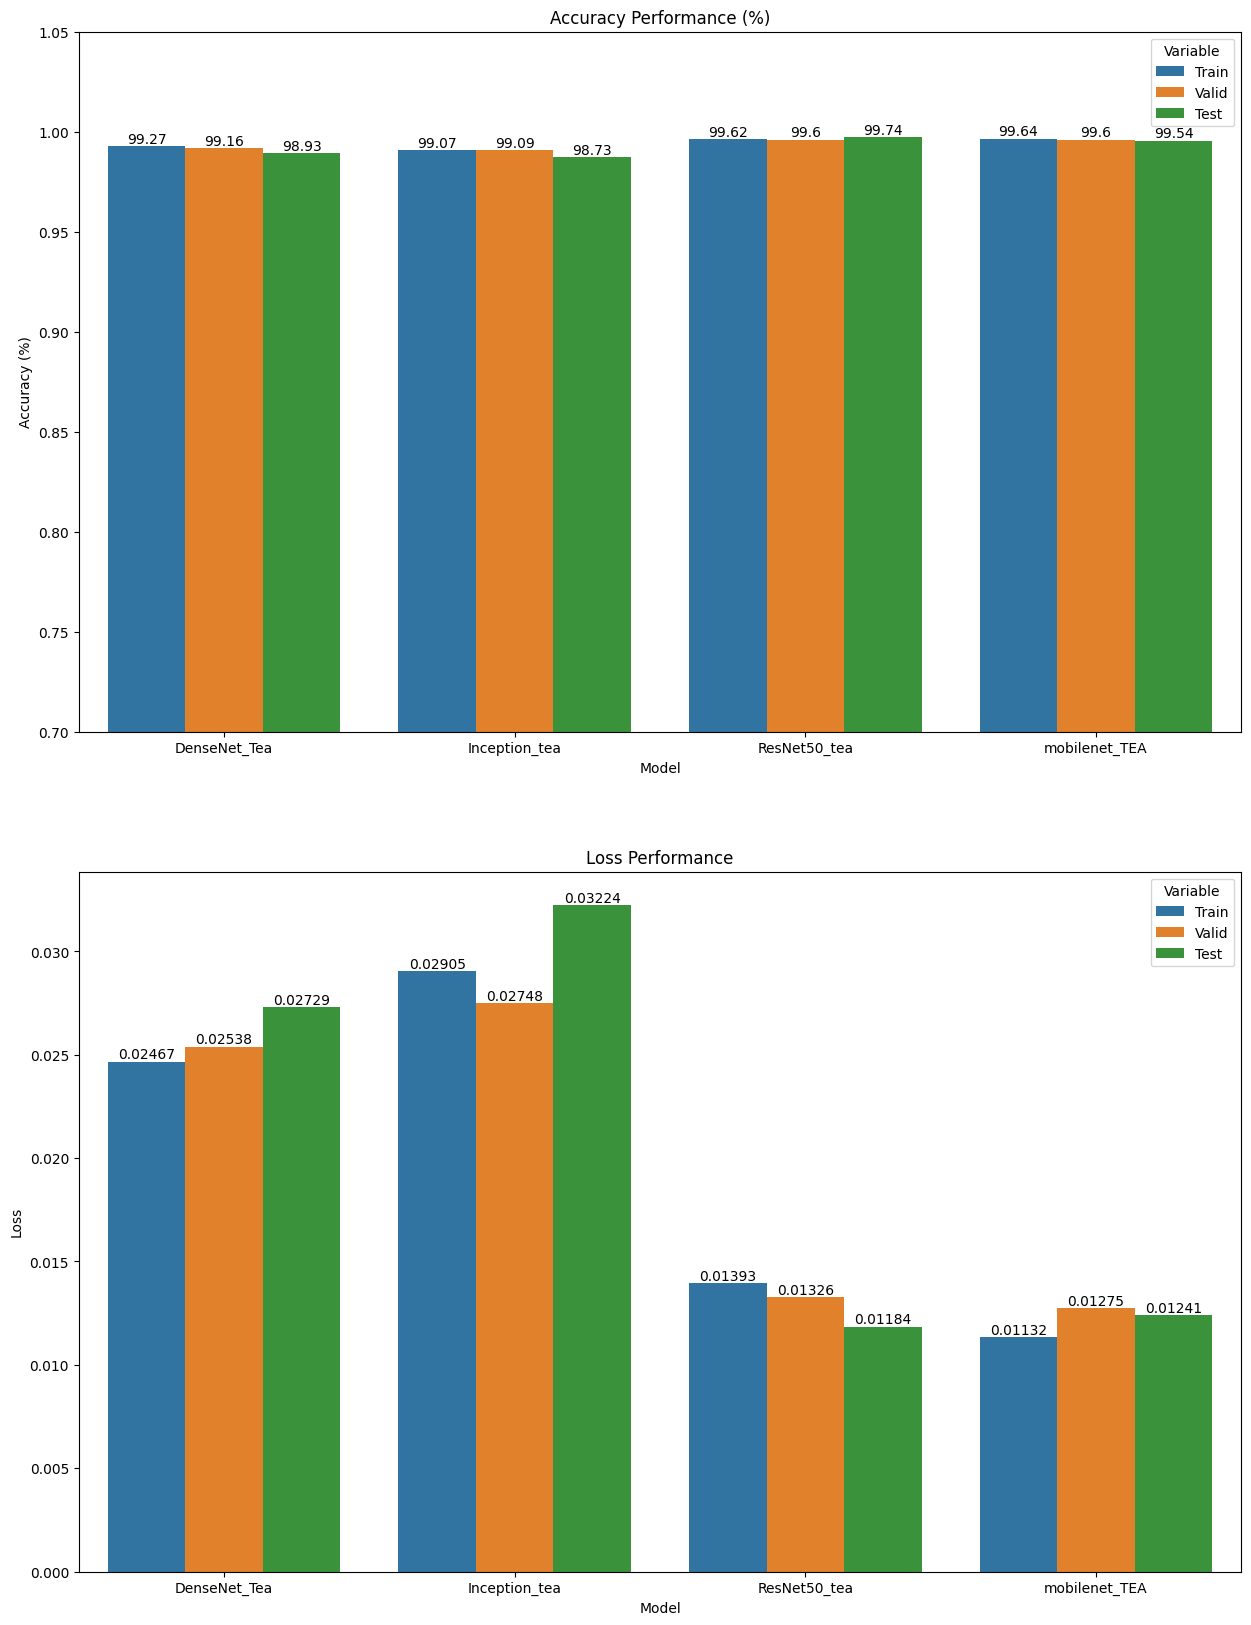

In [35]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

sns.barplot(x='Model', y='Value', hue='Variable', data=tidy1, ax=ax1)
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([0.7 ,1.05])
ax1.set_title('Accuracy Performance (%)')

for p, data in zip(ax1.patches, tidy1['Value']):
    ax1.annotate(round(data*100, 2), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

sns.barplot(x='Model', y='Value', hue='Variable', data=tidy2, ax=ax2)
ax2.set_ylabel('Loss')
ax2.set_title('Loss Performance')

for p, data in zip(ax2.patches, tidy2['Value']):
    ax2.annotate(round(data, 5), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.savefig('corn_all_model_comparisons.png')
plt.show()

## Best Model Conversion

In [39]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model3_resnet)
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = tflite_converter.convert()
open("tf_lite_model_tea.tflite", "wb").write(tflite_model)




  # Use the tool to finally convert the model

25141616